Imports

In [16]:
import warnings
warnings.filterwarnings('ignore')

#################
# My notebook issues
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
sys.path.append('home/egupta/.local/bin')

##############

import os
import numpy as np
import scipy.stats as ss
import networkx as nx
import csv 
import numpy as np
import seaborn as sns
from pandas import DataFrame
from scipy.optimize import curve_fit
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline


##qtensor imports
import qtensor
from qtensor import QAOA_energy
from qtensor import parameter_optimization as popt
import torch

Tranferability Matrix for random subgraphs

In [17]:
def sub_all(d1, d2, draw=False):
    # returns a list of subgraphs of all graphs with nodes of the central edge having degree d1 and d2
    A = np.zeros((d1 + d2, d1 + d2))
    A[d1 + 1:, d1] = 1
    A[:d1 - 1, d1 - 1] = 1
    A[d1 - 1, :d1 - 1] = 1
    A[d1, d1 + 1:] = 1
    A[d1, d1 - 1] = 1
    A[d1 - 1, d1] = 1
    
    g = nx.from_numpy_matrix(np.array(A))

    g_list = [g]
    for i in range(min(d1, d2) - 1):
        g = g_list[i]
        g_list.append(nx.contracted_nodes(g, i, i + d1 + 1))
    # relabel center edge as (0, 1)
    for i, g in enumerate(g_list):
        g_list[i] = qtensor.tools.lightcone_orbits.relabel_edge_first(g, (d1 - 1, d1))
        if draw:
            nx.draw_kamada_kawai(g)
            plt.show()
    return g_list

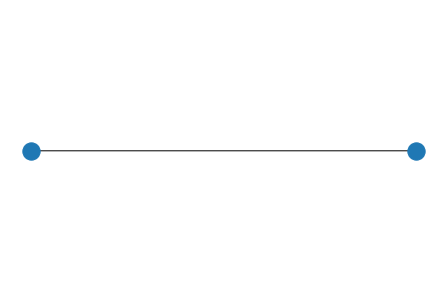

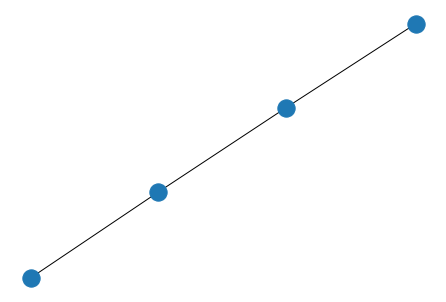

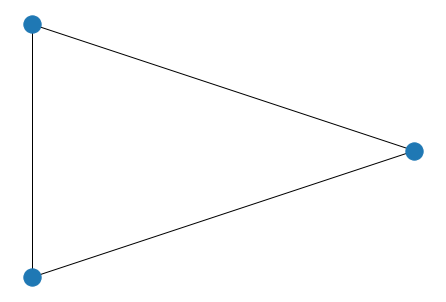

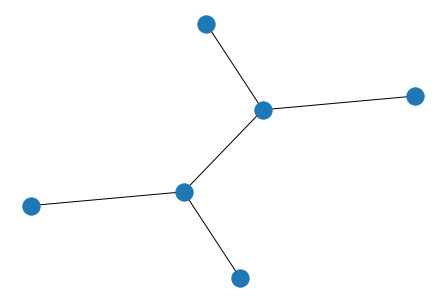

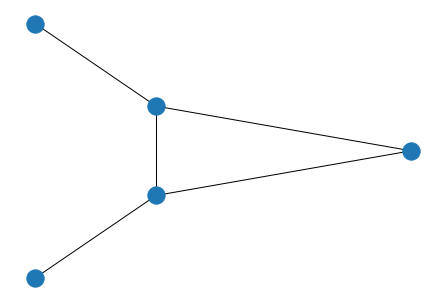

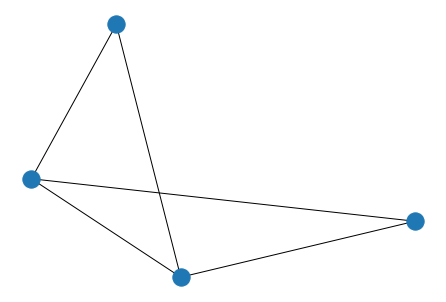

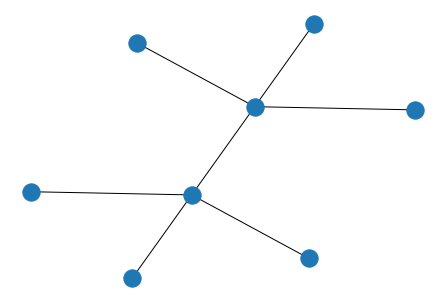

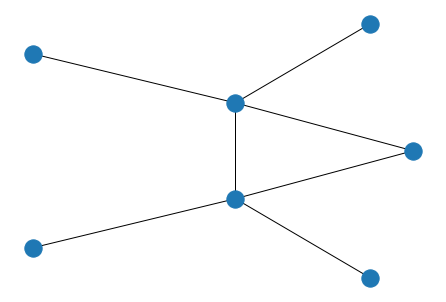

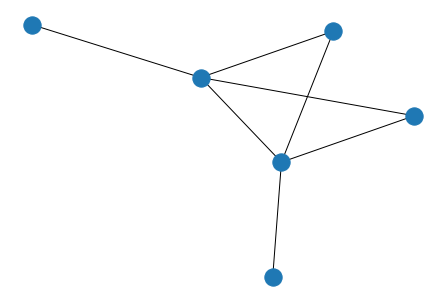

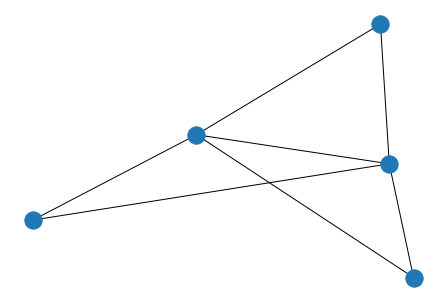

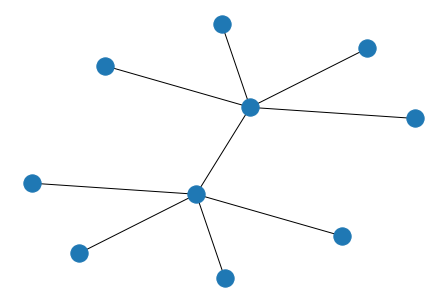

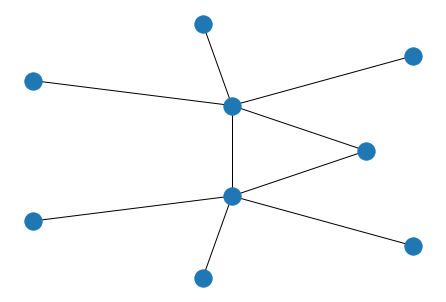

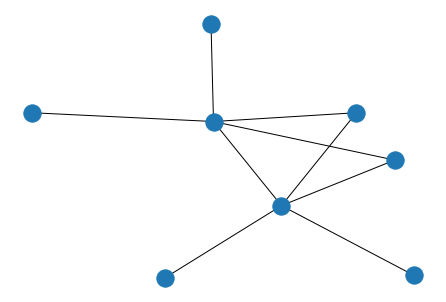

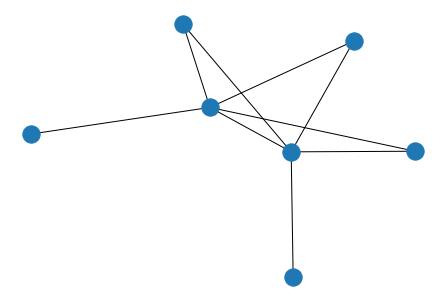

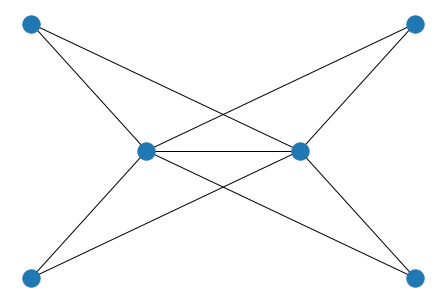

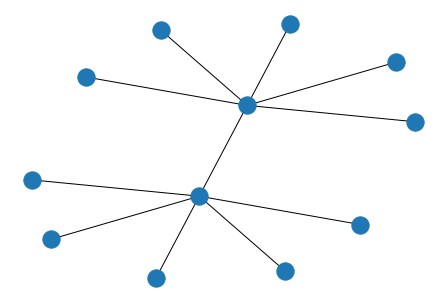

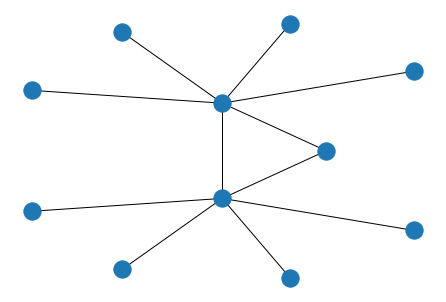

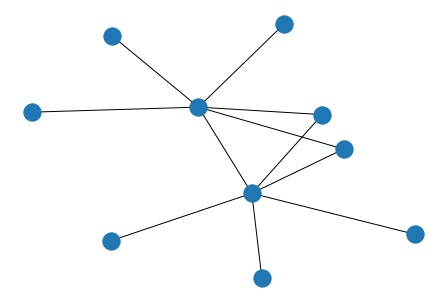

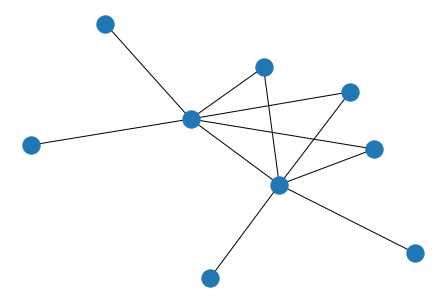

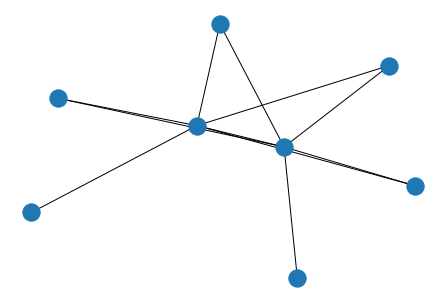

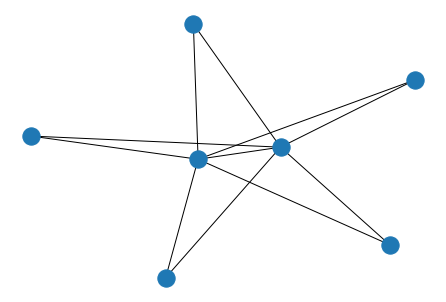

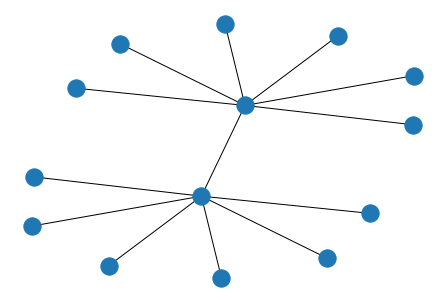

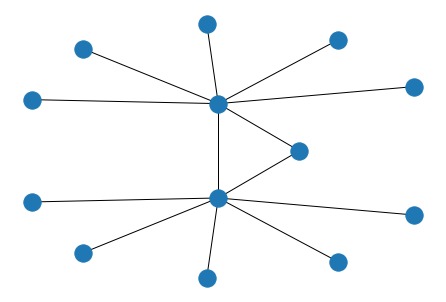

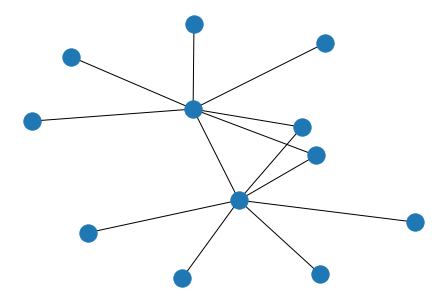

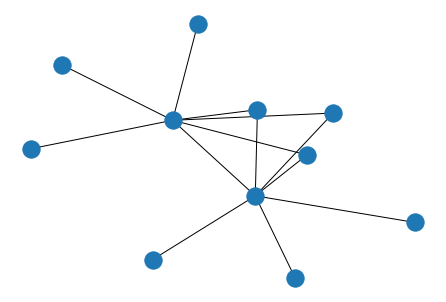

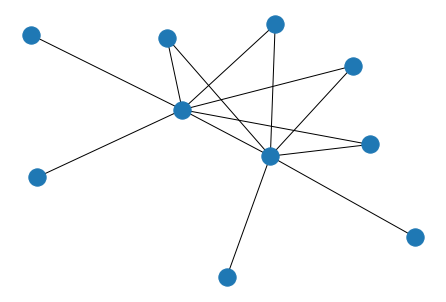

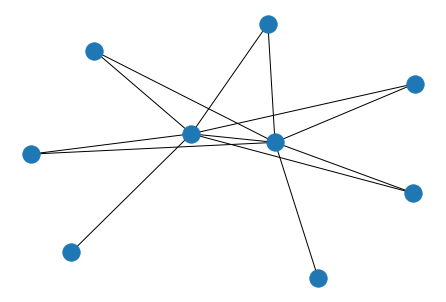

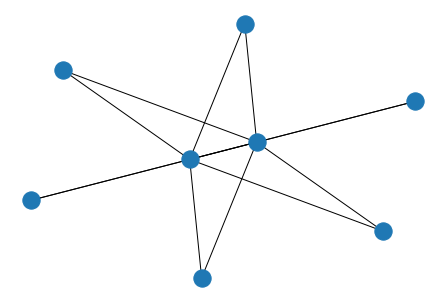

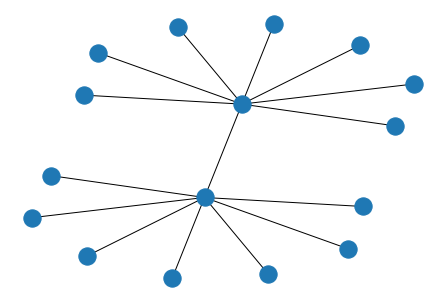

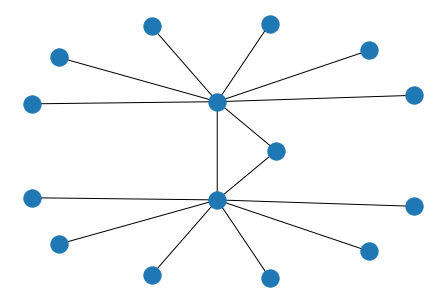

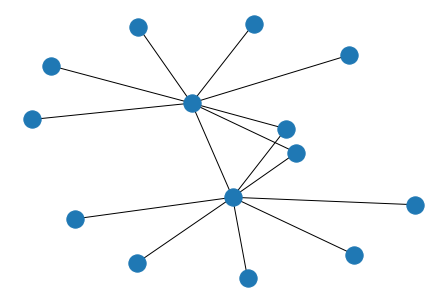

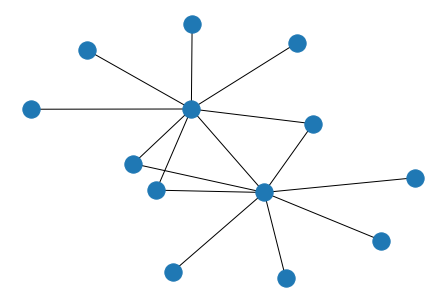

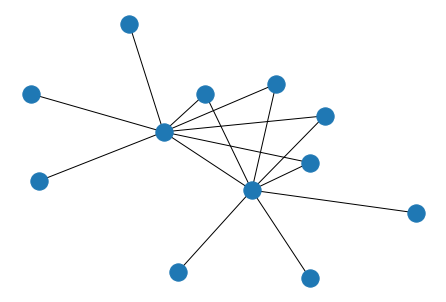

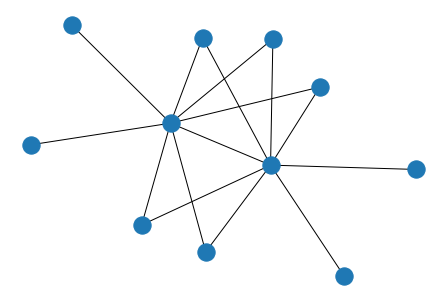

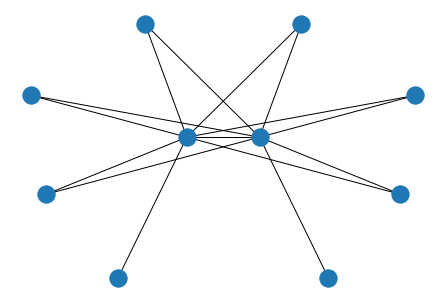

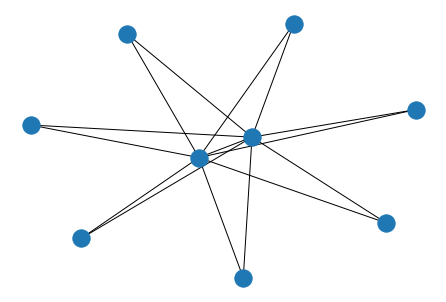

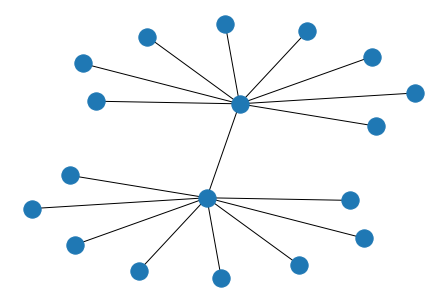

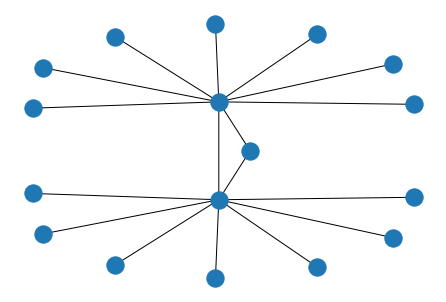

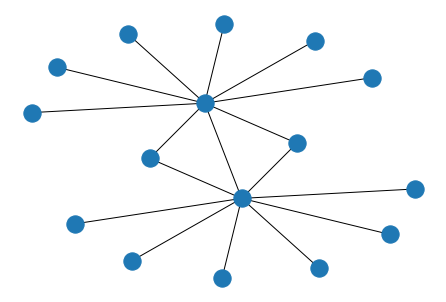

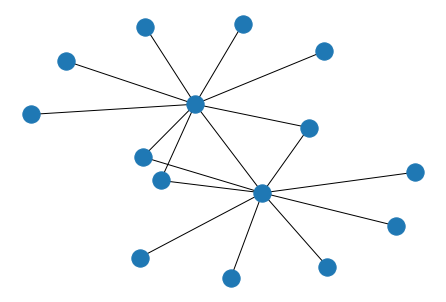

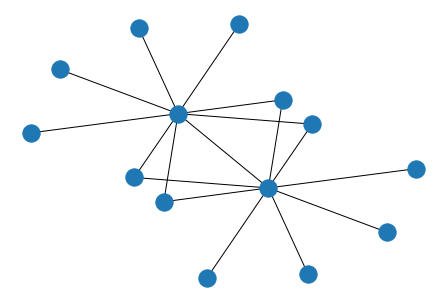

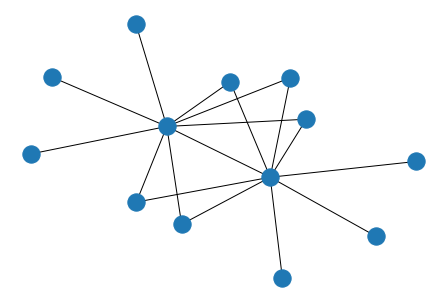

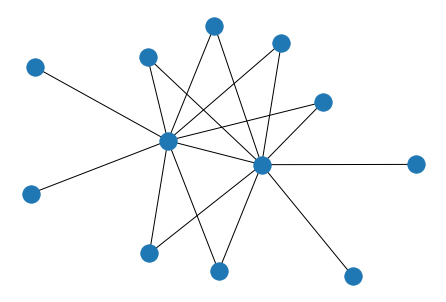

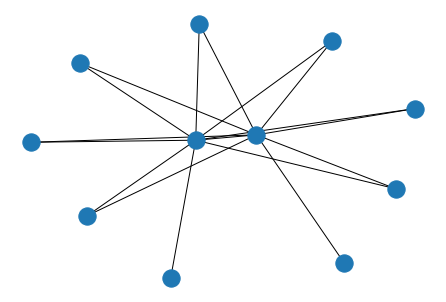

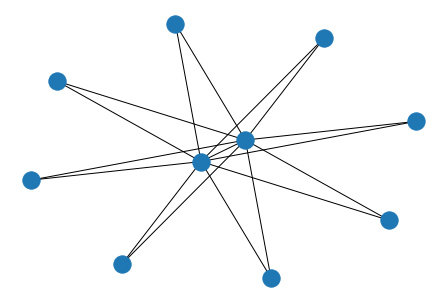

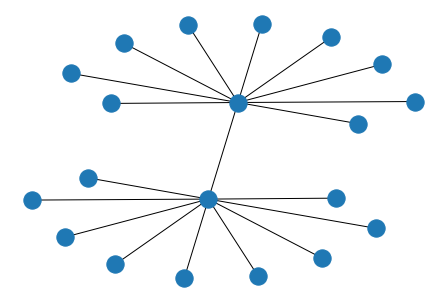

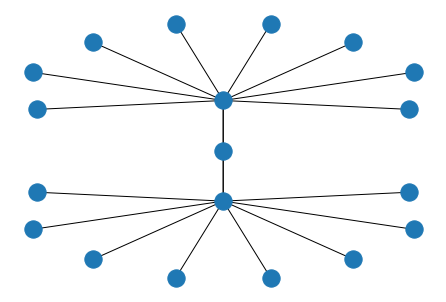

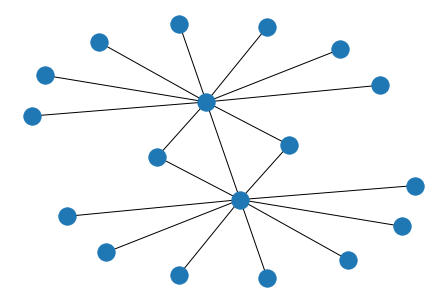

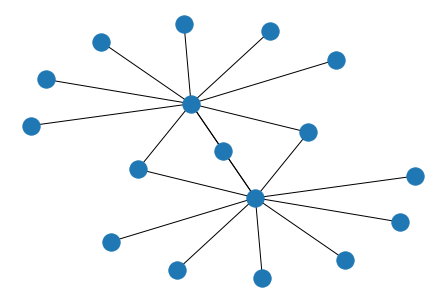

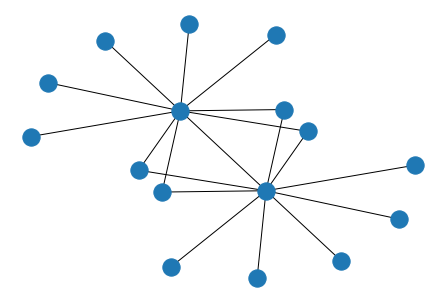

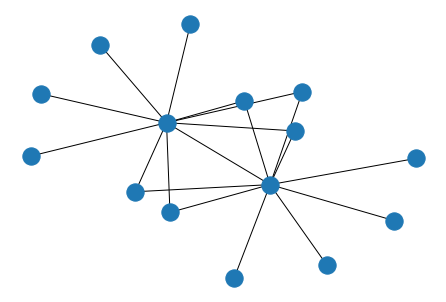

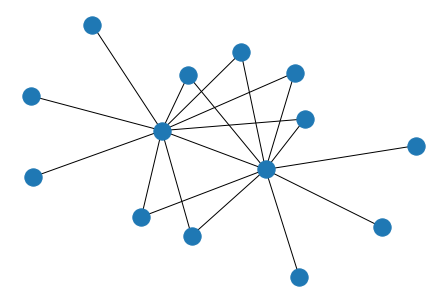

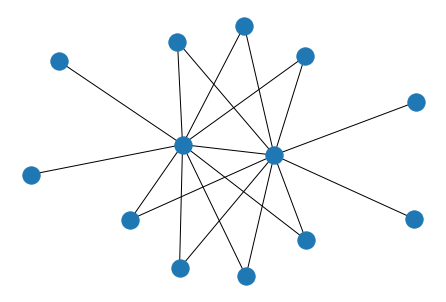

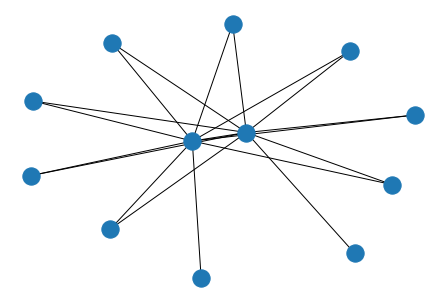

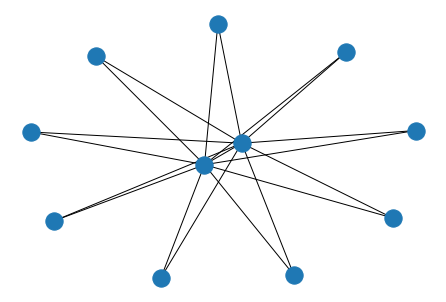

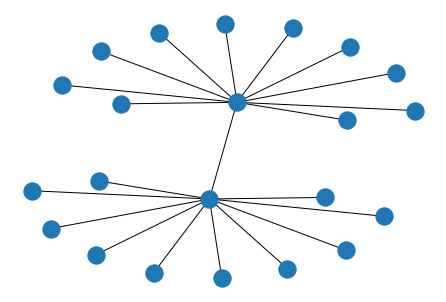

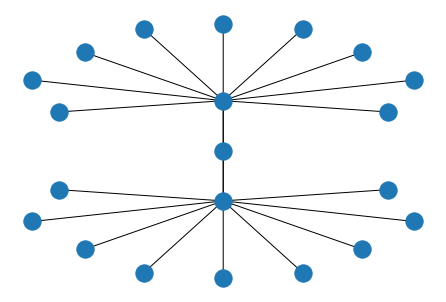

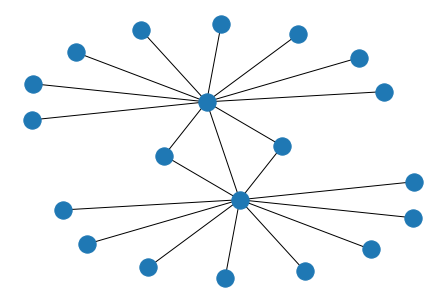

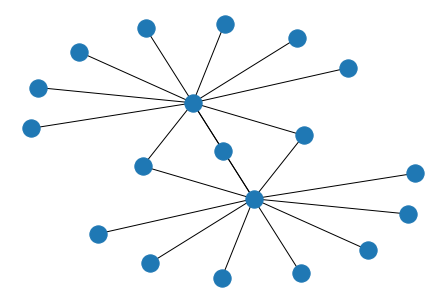

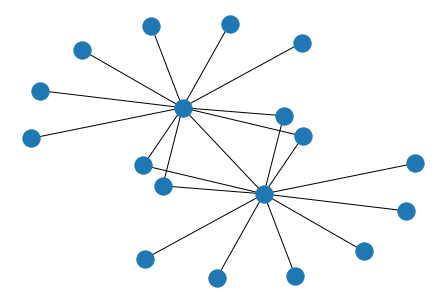

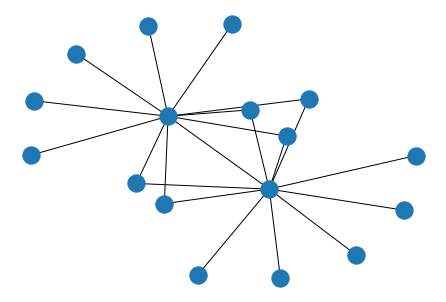

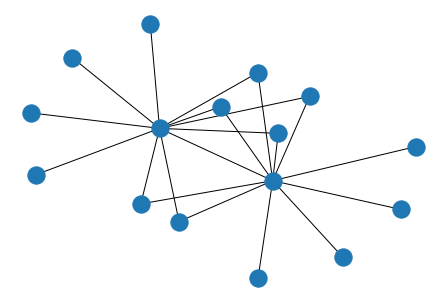

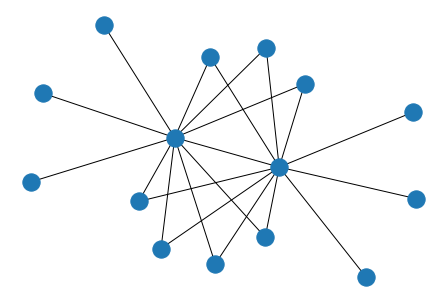

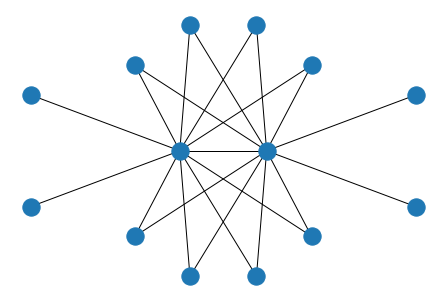

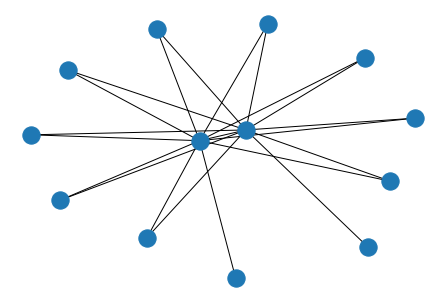

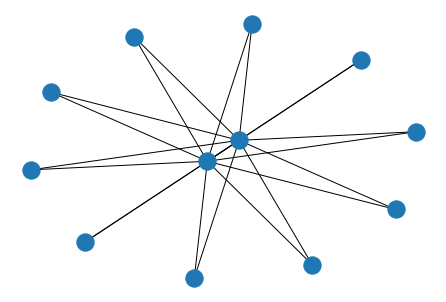

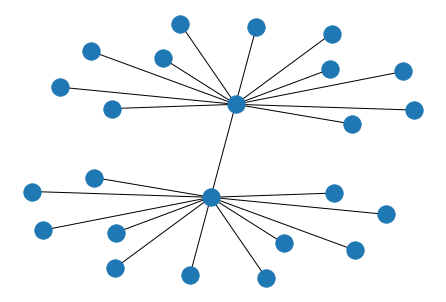

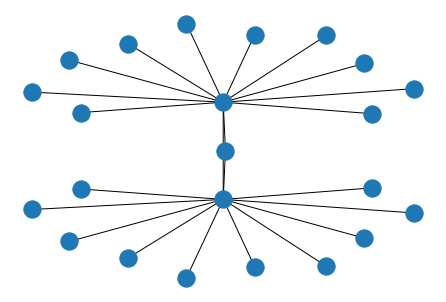

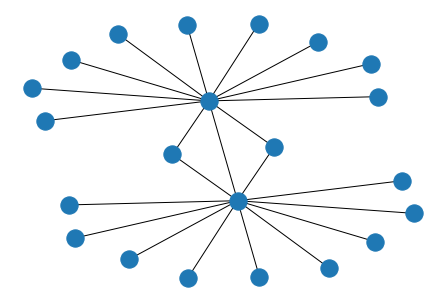

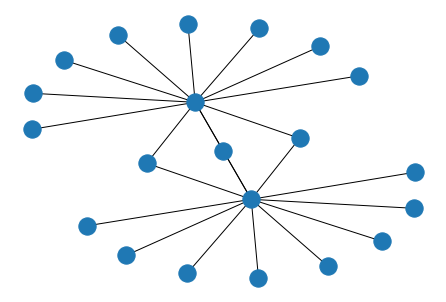

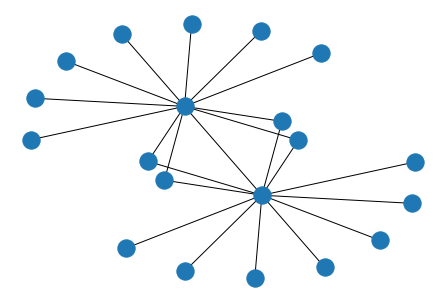

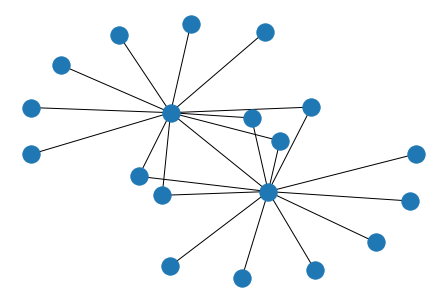

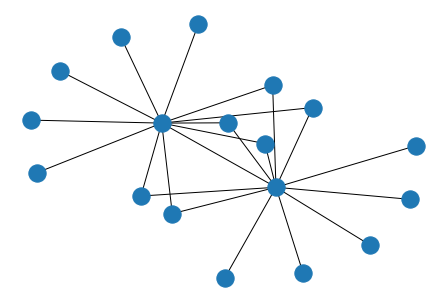

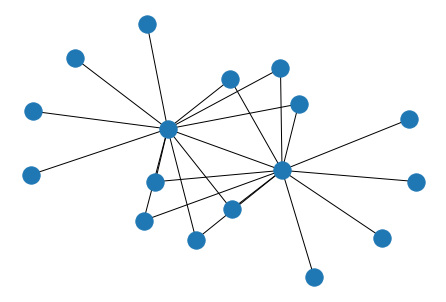

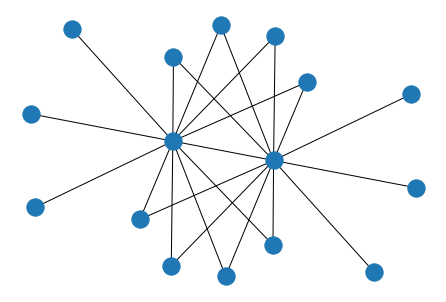

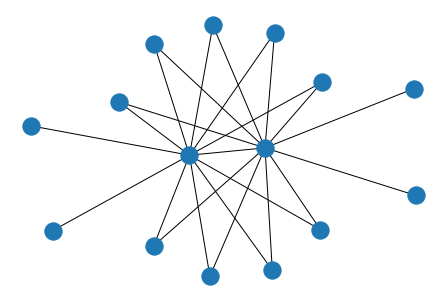

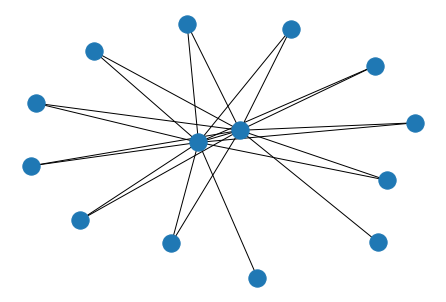

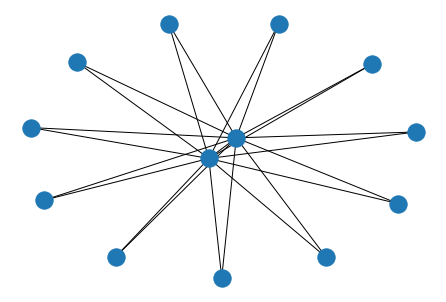

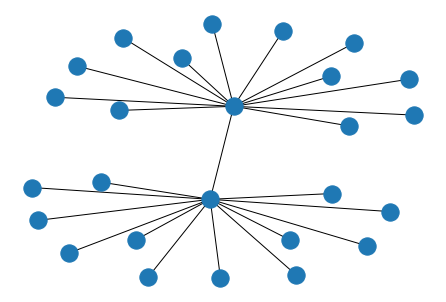

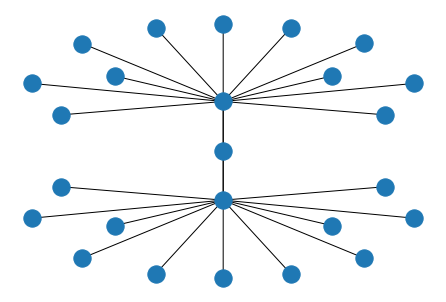

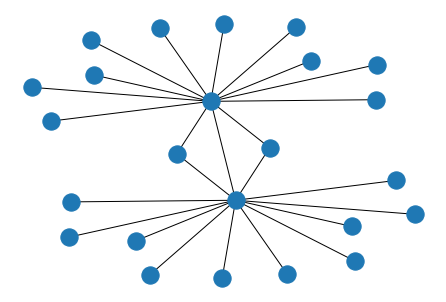

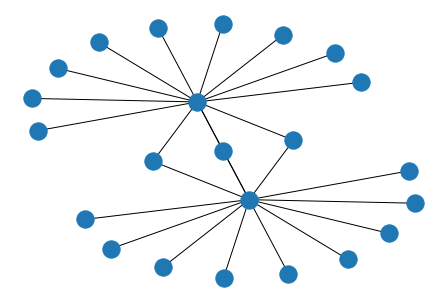

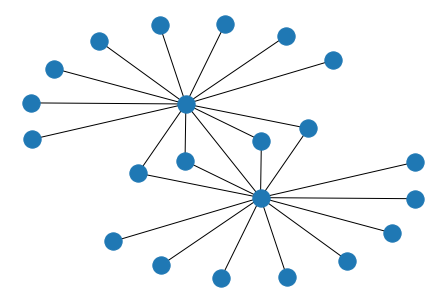

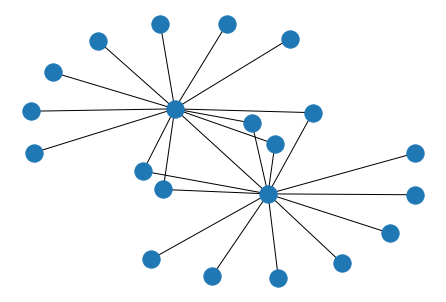

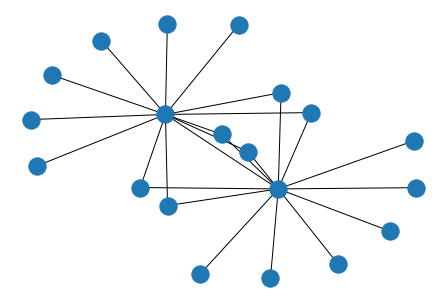

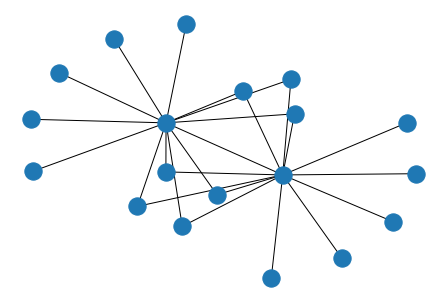

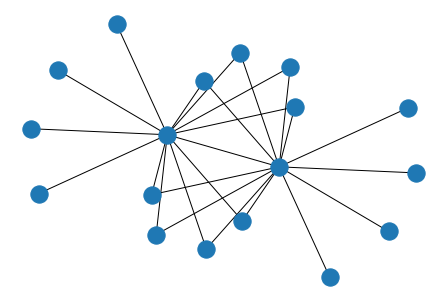

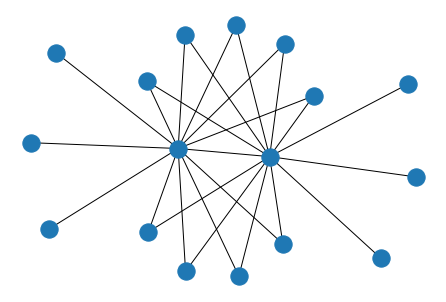

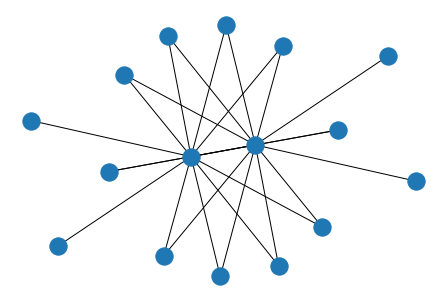

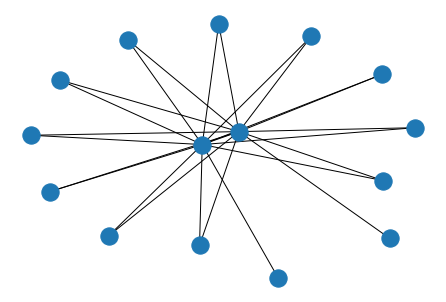

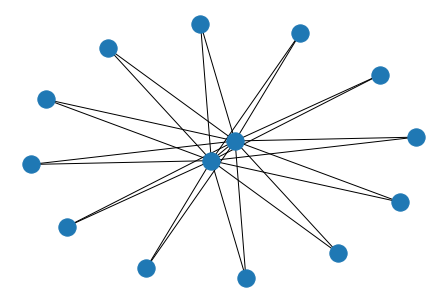

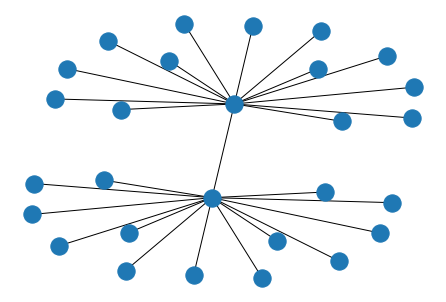

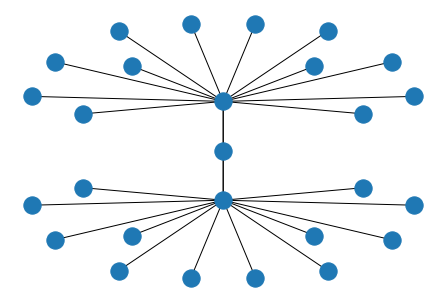

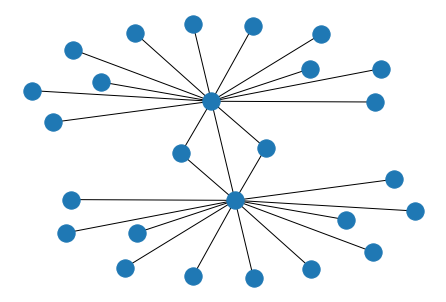

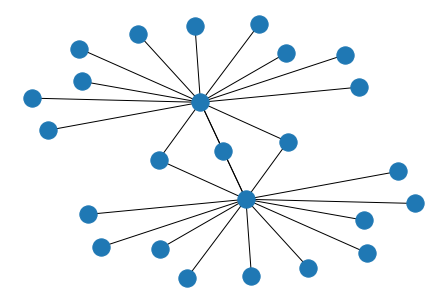

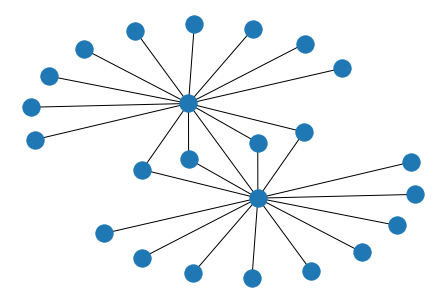

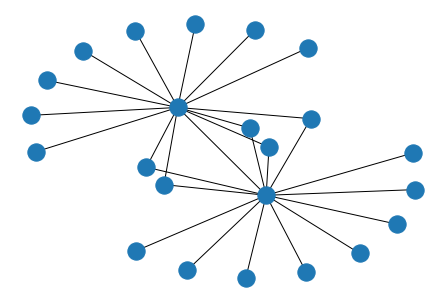

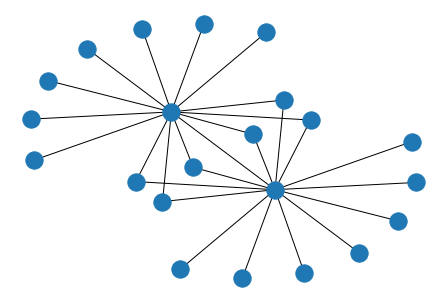

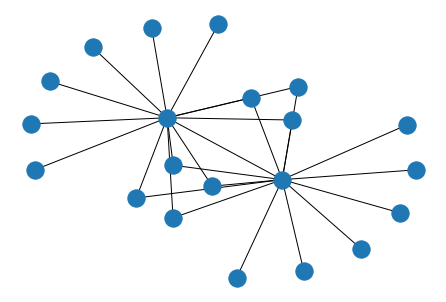

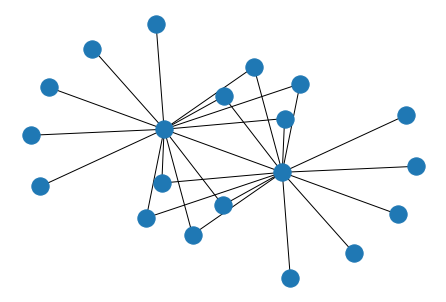

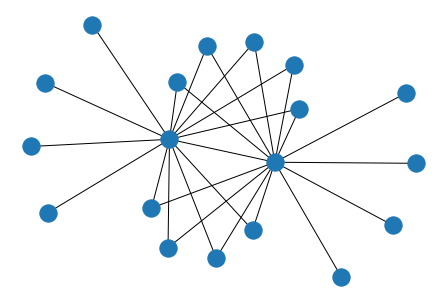

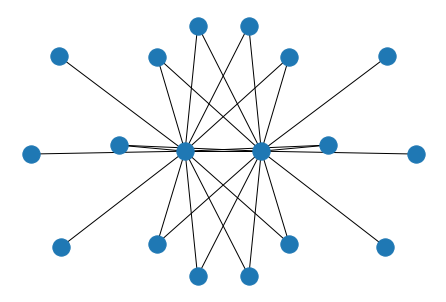

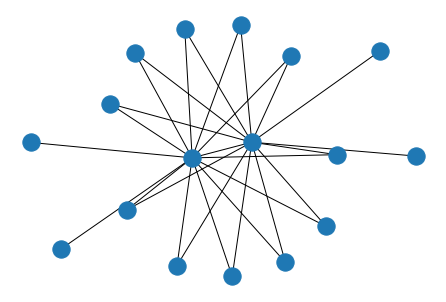

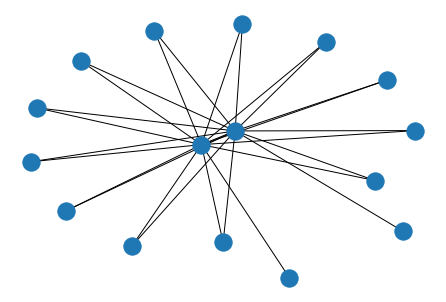

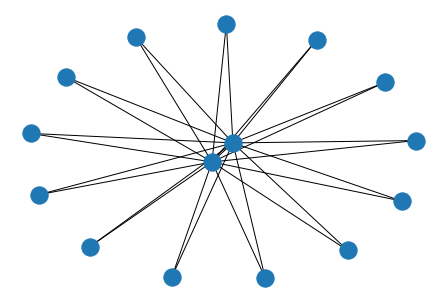

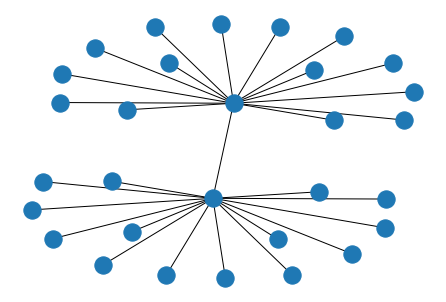

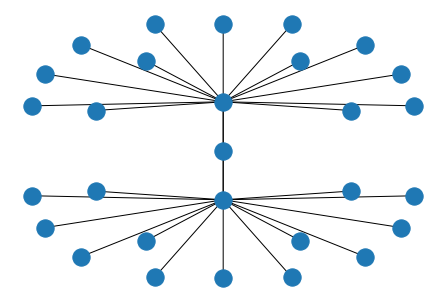

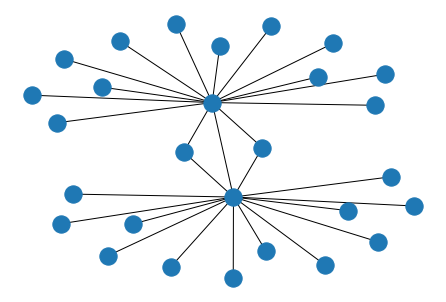

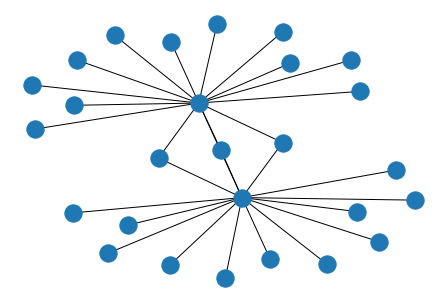

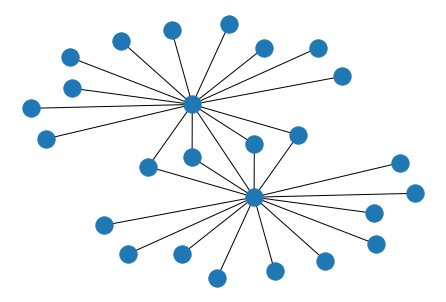

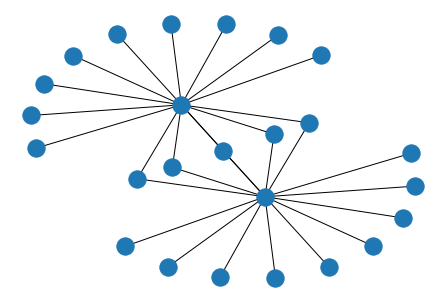

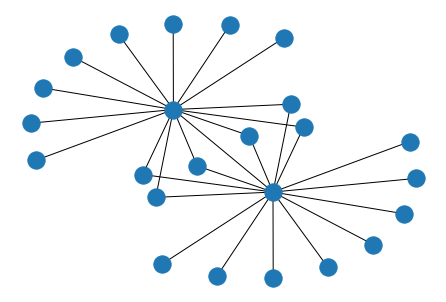

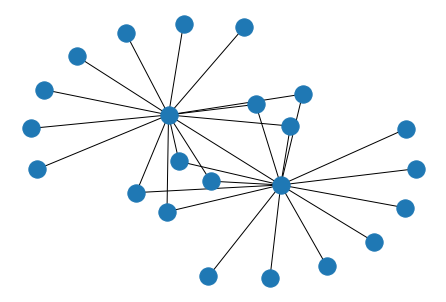

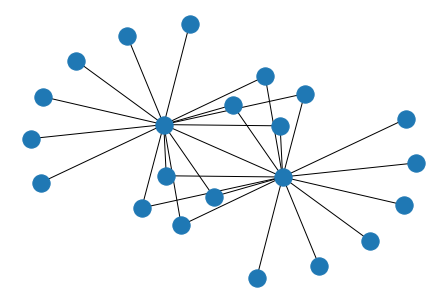

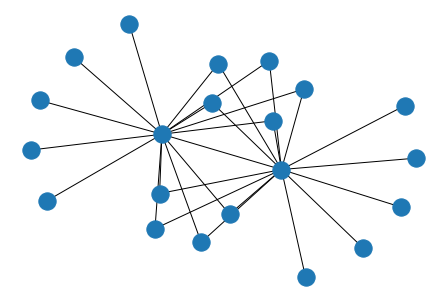

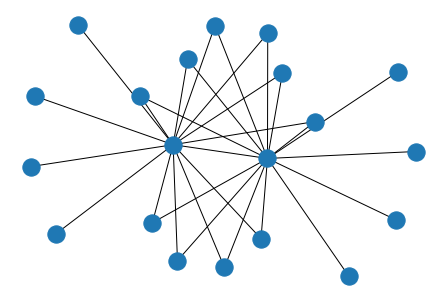

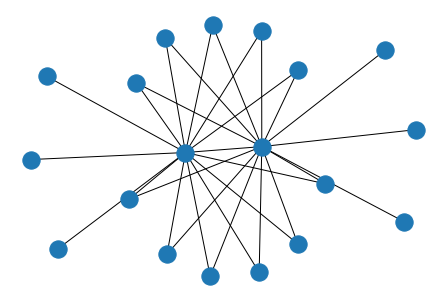

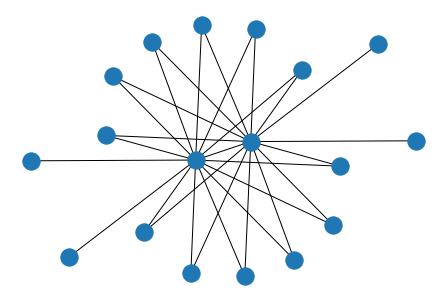

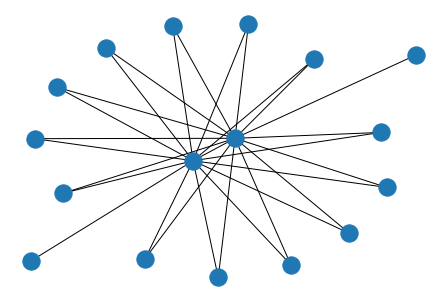

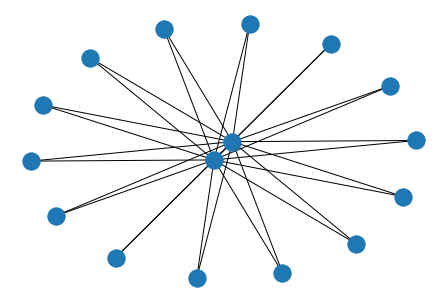

In [18]:
#generating all subgraphs first 
g_all = []
indexes = [] #for numbering later
d = 1
dmax = 15
step = 1
while d<= dmax:
  g_subs = sub_all(d, d, True)
  indexes += [d for i in range(len(g_subs))]
  g_all += g_subs
  d+=step

In [19]:
file1 = open("/home/egupta/Documents/Eesh's Experiments/Transferability Matrices/transferability_matrix_regular_subgraphs_1_15.txt")
file2 = open("/home/egupta/Documents/Eesh's Experiments/Transferability Matrices/mod_transferability_matrix_regular_subgraphs_1_15.txt")

In [20]:
tranf_mat_orig = np.loadtxt(file1).reshape(120,120)
tranf_mat_mod = np.loadtxt(file2).reshape(120,120)

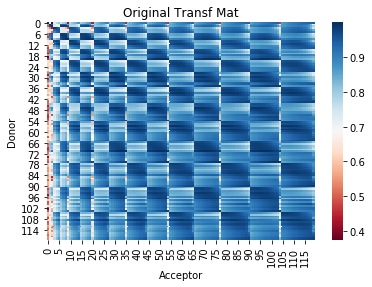

In [21]:
df = DataFrame(tranf_mat_orig)#, index=Index, columns=Cols)
sns.heatmap(df, annot=False, cmap="RdBu")
plt.title("Original Transf Mat")
plt.ylabel('Donor')
plt.xlabel('Acceptor')
plt.show()

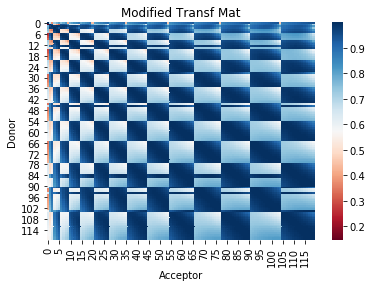

In [22]:
df = DataFrame(tranf_mat_mod)#, index=Index, columns=Cols)
sns.heatmap(df, annot=False, cmap="RdBu")
plt.title("Modified Transf Mat")
plt.ylabel('Donor')
plt.xlabel('Acceptor')
plt.show()

In [23]:
tranf_mat = tranf_mat_orig

# Identifying Subgraphs of a Graph

In [24]:
def find_index(g, subgraphs):
    """
    finds index of subgraph g is isomorphic with
    """
    i = 0
    while i<len(subgraphs):
        if nx.is_isomorphic(g, subgraphs[i]):
            return i
        i+=1
    print('error: could not find subgraph')
    return -1
def find_subgraphs(G):
  '''
  Input: A graph G
  Output: A dictionary containg subgraphs and their frequency in G
  '''
  edges_done = []
  subgraphs = {}

  vertices = G.nodes
  for v1 in vertices:
    ######print('----------------------------------------')
    ######print('Parent checking for vertex ' +str(v1) )
    neighbors = nx.all_neighbors(G,v1)
    ######print(neighbors)
    #iterate over edges
    for v2 in neighbors:
      ######print('Childchecking for vertex ' +str(v2) )
      ##if already there
      if (v1,v2) in edges_done:
        #######print('Already looked at')
        continue
      ##add if not there
      else:
        ######print('Not looked at')
        edges_done.append((v1,v2))
        edges_done.append((v2,v1))
      
      neighbors1 = nx.all_neighbors(G,v1)
      neighbors2 = nx.all_neighbors(G, v2)

      subg_edge_set = []
      for v in neighbors1:
        #######print(v)
        edge = (v1, v)
        subg_edge_set.append(edge)

      for v in neighbors2:
        ######print(v)
        if v is not v1:
          edge = (v2, v)
          subg_edge_set.append(edge)

      ##creating the subgraph
      H = G.edge_subgraph(subg_edge_set)

      ##check if isomorphic with any other subgraphs
      iso = False
      subgraphs_arr = subgraphs.keys()
      for subgraph in subgraphs_arr:
        if nx.is_isomorphic(H, subgraph):
          #######print('is isomorphic')
          subgraphs[subgraph] +=1
          iso = True
          break
      if iso == False:
        #######print('---------------Adding a subgraph--------------------')
        subgraphs[H] = 1
        ######print(subgraphs)
  return subgraphs

# Similiarity between 2 graphs

In [25]:
def similarity(G1, G2, subgraphs = g_all, tranf_mat = tranf_mat):
  """
  Compute similarity metric between 2 graphs
  """
  sub_g1_dict = find_subgraphs(G1)
  sub_g2_dict = find_subgraphs(G2)
  sub_g1 = sub_g1_dict.keys()
  sub_g2 = sub_g2_dict.keys()
  metric = 0
  total_arrows = 0

  for donor in sub_g1:
    for acceptor in sub_g2:
      arrows = sub_g1_dict[donor]*sub_g2_dict[acceptor]
      i = find_index(donor, subgraphs)
      j = find_index(acceptor, subgraphs)
      metric+= arrows*tranf_mat[i,j]
      total_arrows += arrows
  metric = metric/total_arrows
  return metric

In [26]:
from qtensor import QAOA_energy

def actual_sim(G1, G2,g1_results, g2_results):
  """
  Returns similarity between two graphs computed directly
  """
  #Now computing similarity
  sim = 0
  acc_max_energy = g2_results[2]
  donor_gamma = g1_results[0]
  donor_beta = g1_results[1]

  transf_energy = QAOA_energy(G2, [donor_gamma], [donor_beta])
  #print(transf_energy)
  sim = transf_energy/acc_max_energy
  return sim

In [77]:
def mutual_similarity(G1, subgraphs = g_all, tranf_mat = tranf_mat):
  """
  Compute subgraph similarity metric within a graph
  """
  sub_g1_dict = find_subgraphs(G1)
  sub_g1 = sub_g1_dict.keys()
  metric = 0
  total_arrows = 0

  for donor in sub_g1:
    for acceptor in sub_g1:
      if (nx.is_isomorphic(donor, acceptor) is False):
        #print('hi')
        arrows = sub_g1_dict[donor]*sub_g1_dict[acceptor]
        i = find_index(donor, subgraphs)
        j = find_index(acceptor, subgraphs)
        metric+= arrows*tranf_mat[i,j]
        total_arrows += arrows
        #print(arrows)
  if metric!=0:
      metric = metric/total_arrows
  else:
    metric = 1
  return metric

# Getting the graphs data

In [33]:
file3 = open('16NodeFullData.txt', 'r')
Lines = file3.readlines()
 
count = 0
g_data = []
# Strips the newline character
for line in Lines:
    mod_line = line.strip()
    vals = mod_line.split(',')
    vals = [float(i) for i in vals]
    g_data.append(vals)
    #print("Line{}: {}".format(count, line.strip()))
print(len(g_data))

59


In [35]:
file4 = open('16NodeFullGraphs.txt', 'r')
Lines = file4.readlines()
 
count = 0
arrays = []
# Strips the newline character
for line in Lines:
    mod_line = line.strip()
    vals = mod_line.split(',')
    vals = [float(i) for i in vals]
    arrays.append(vals)
    #print("Line{}: {}".format(count, line.strip()))
print(len(arrays))

930


In [37]:

mat_list = []
### 2 node matrix (1-deg graph)
mat_list.append(arrays[0:2])
#only look at firs
#convert bunch of rows to matrices
resi = arrays[2:]
n = int(len(resi)/16)
for i in range(n):
  array = []
  for j in range(16):
    row = resi[i*16 +j]
    row = [float(k) for k in row]
    array.append(row)
  mat_list.append(array)

In [38]:
def mats_to_graphs(mat_list):
  """
  Given list of adjaceny matrix repr of graphs, converts to actual graphs
  """
  g_list = []
  for mat in mat_list:
    arr = np.array(mat)
    G = nx.convert_matrix.from_numpy_matrix(arr)
    g_list.append(G)
  return g_list

In [39]:
g_list = mats_to_graphs(mat_list)

In [40]:
len(g_data)

59

In [41]:
len(g_list)

59

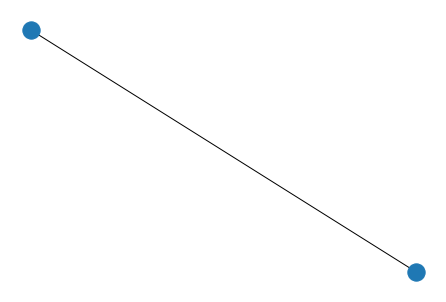

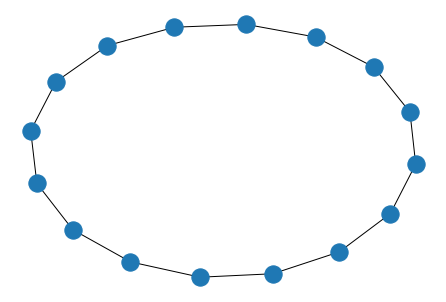

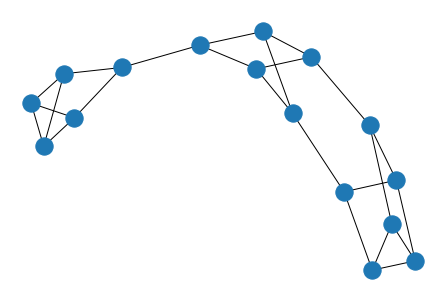

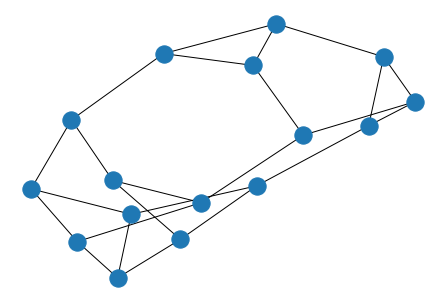

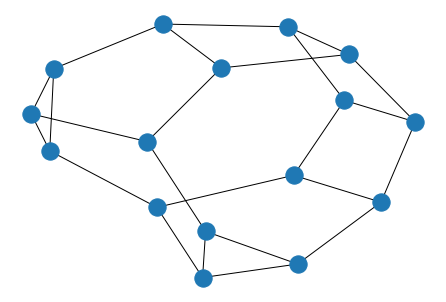

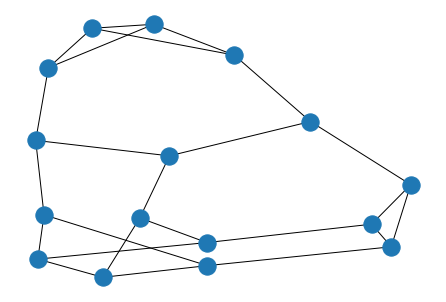

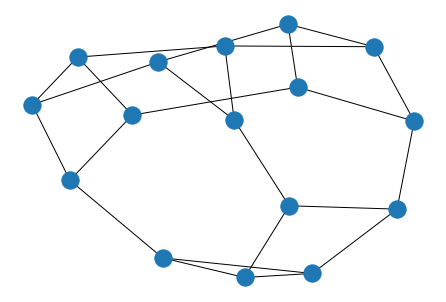

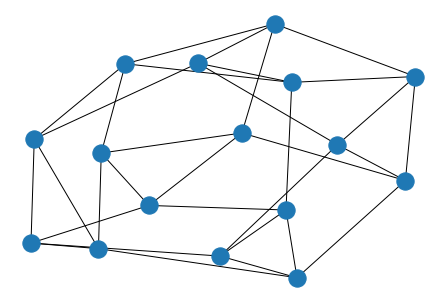

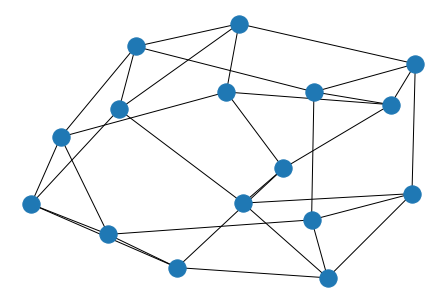

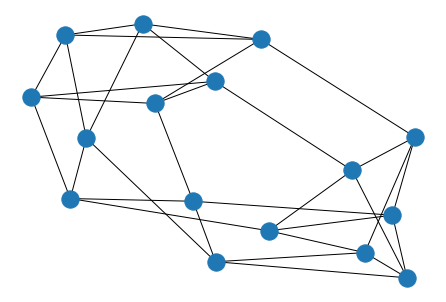

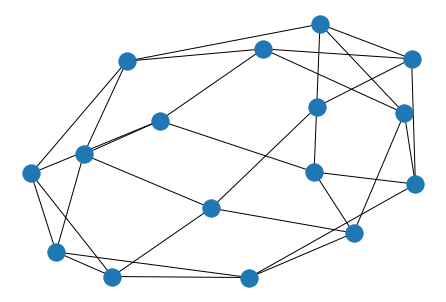

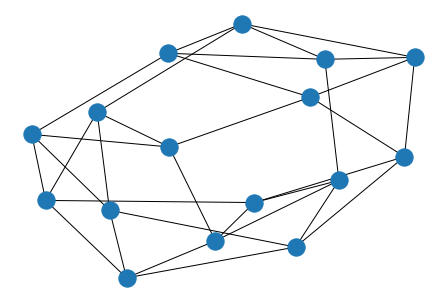

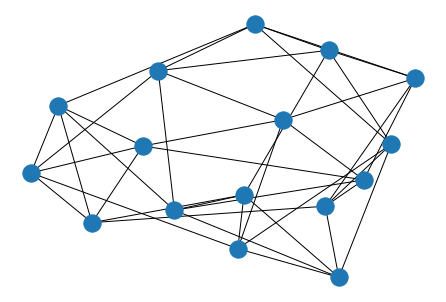

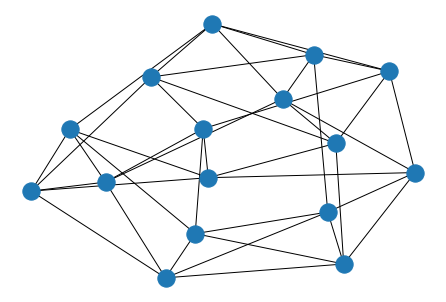

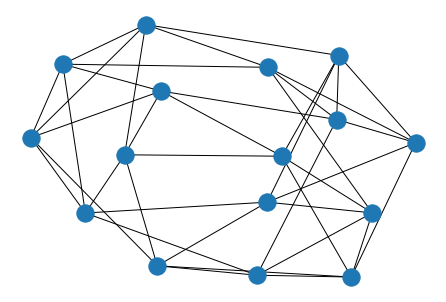

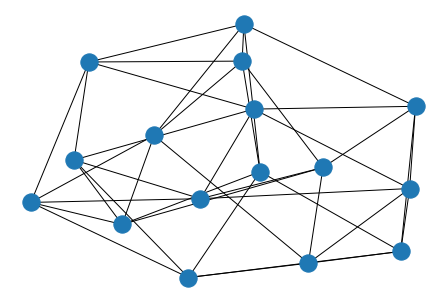

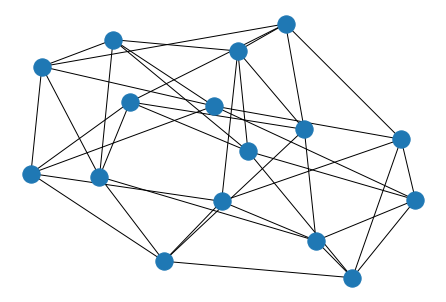

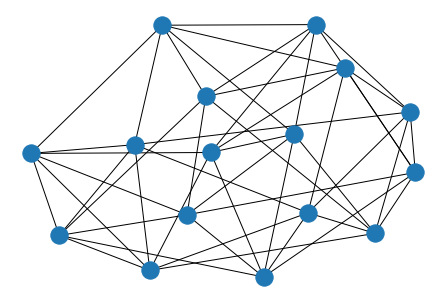

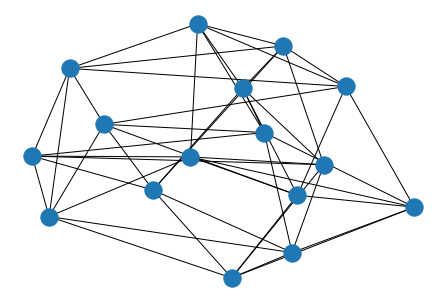

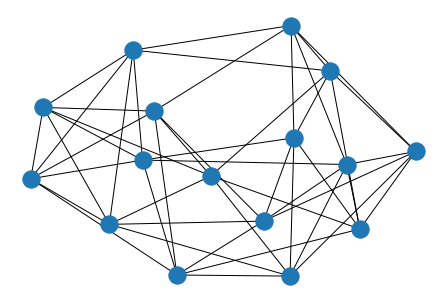

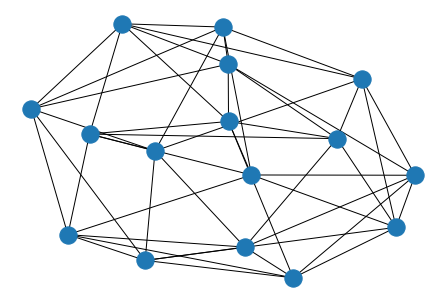

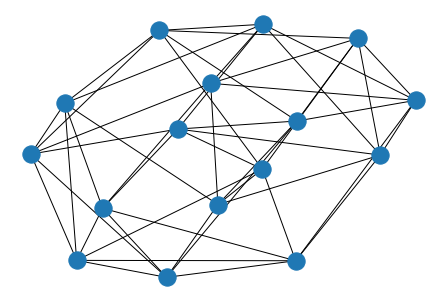

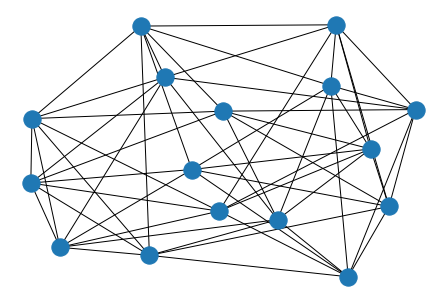

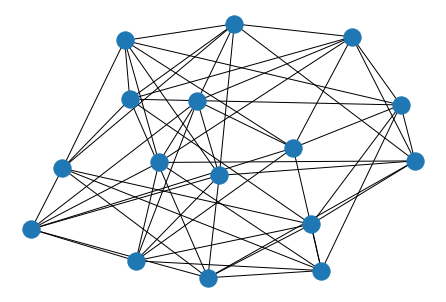

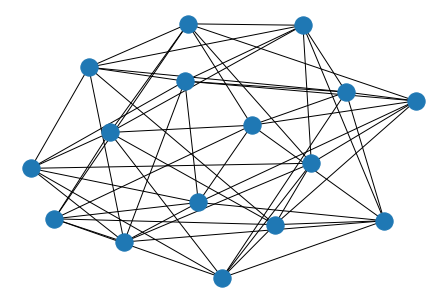

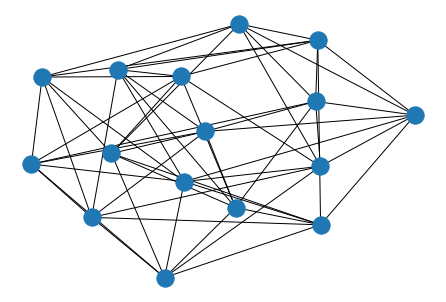

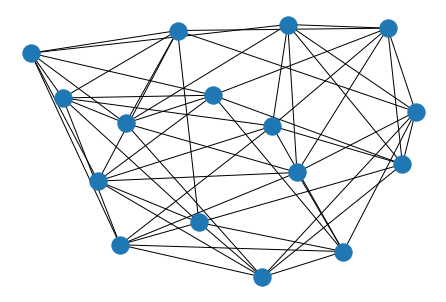

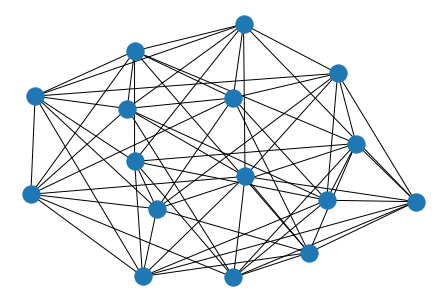

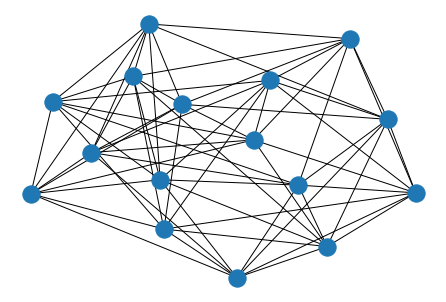

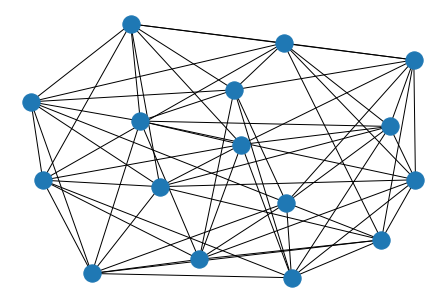

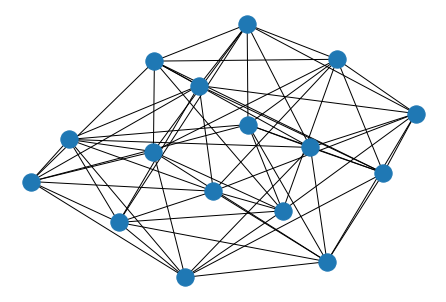

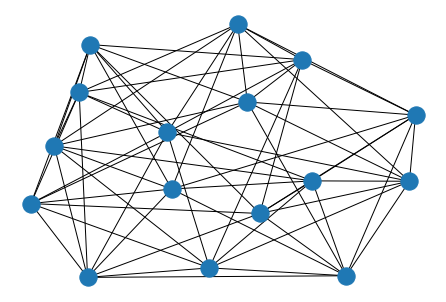

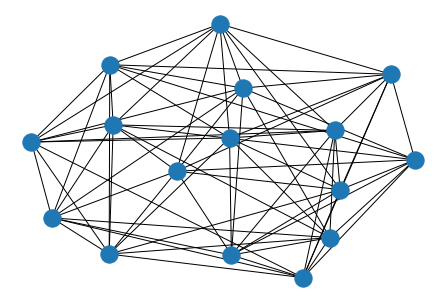

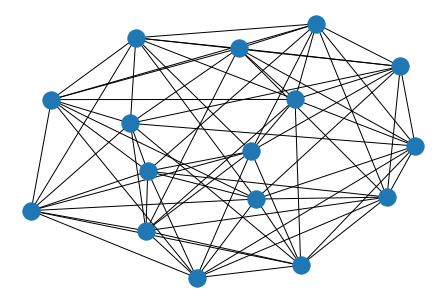

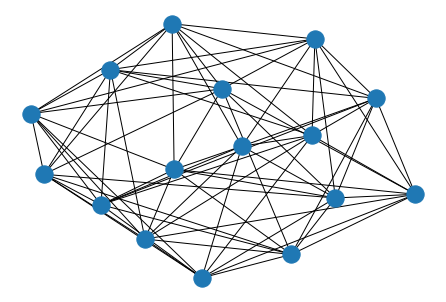

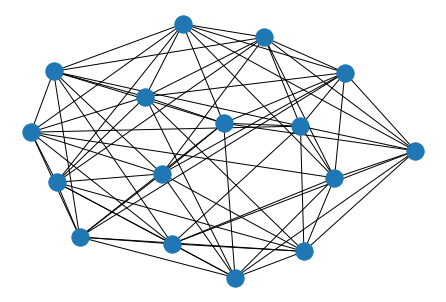

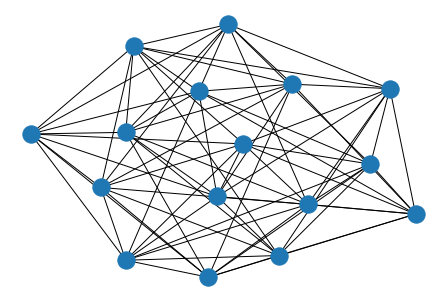

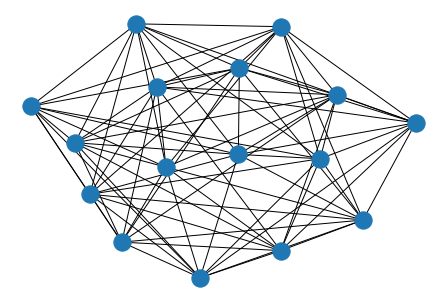

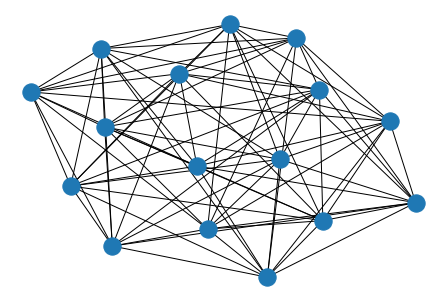

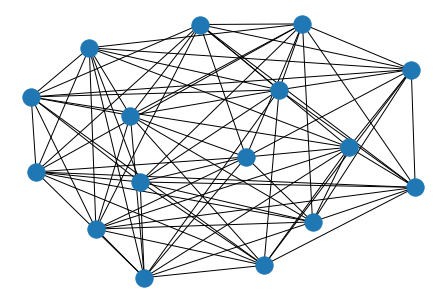

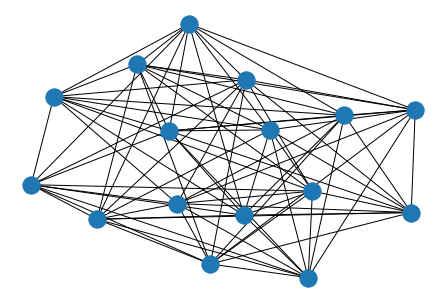

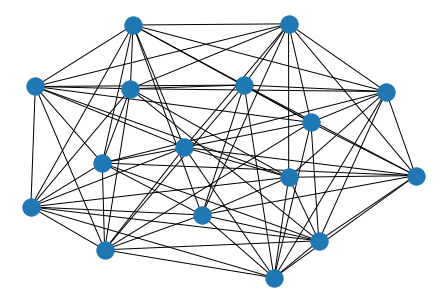

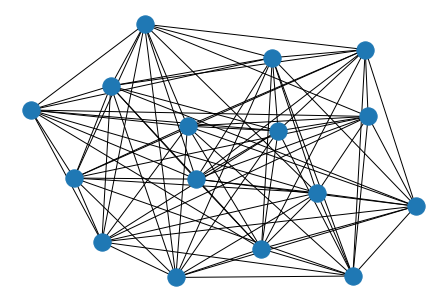

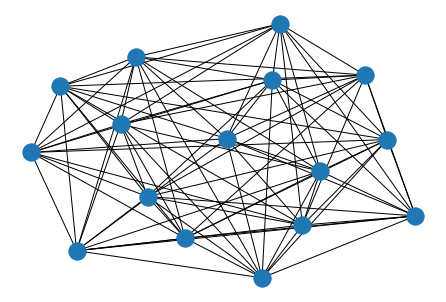

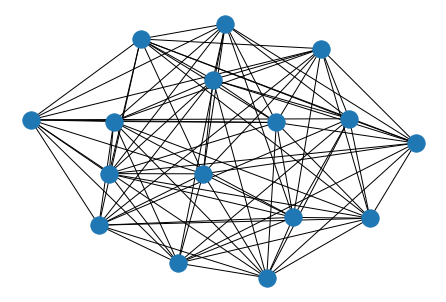

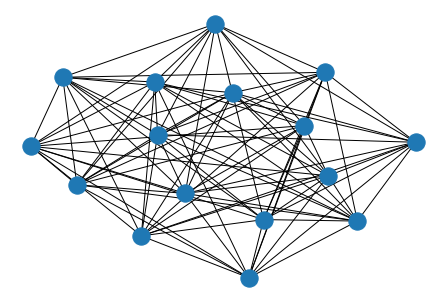

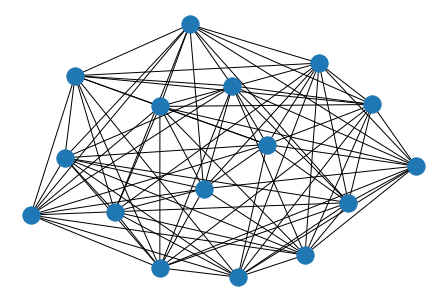

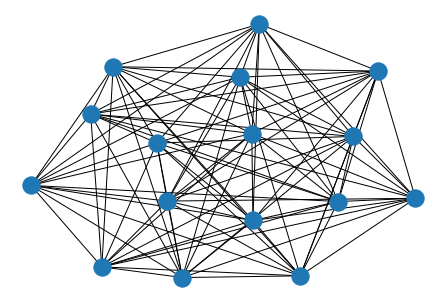

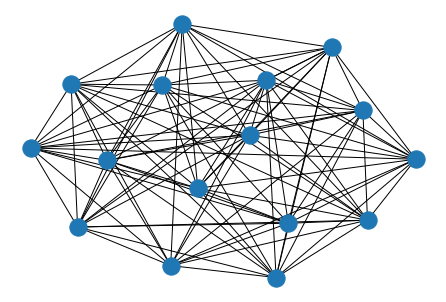

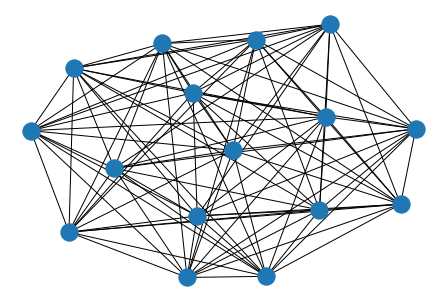

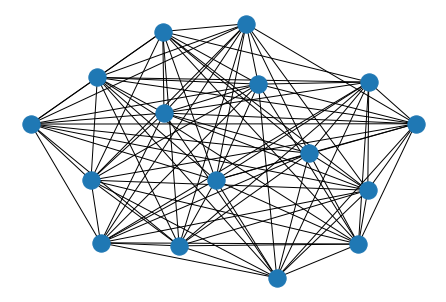

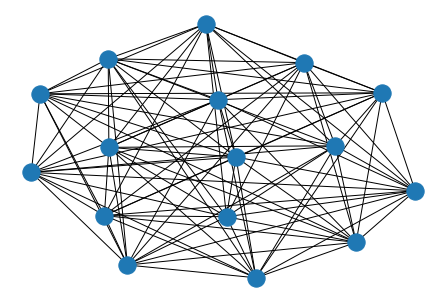

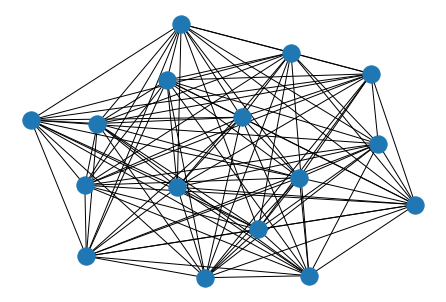

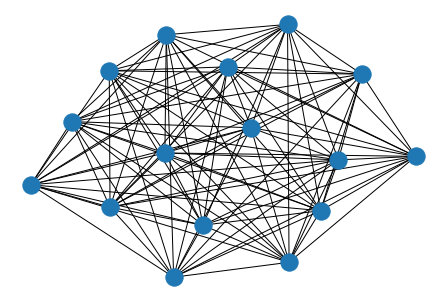

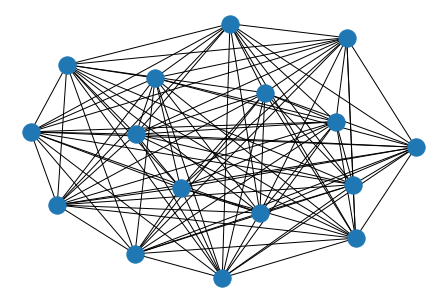

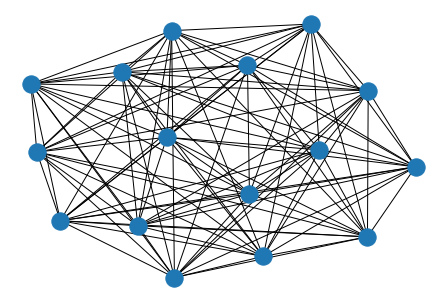

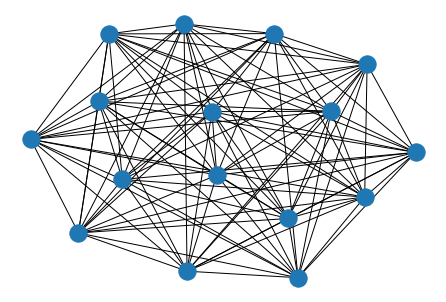

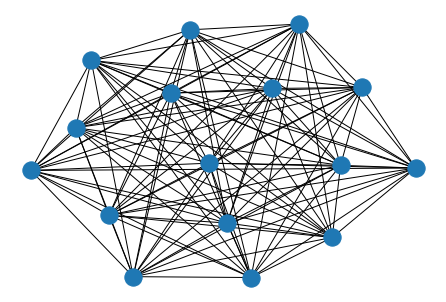

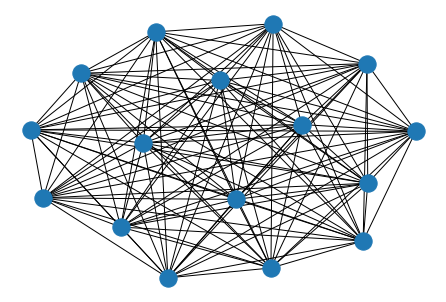

In [42]:
for i in g_list:
  nx.draw(i)
  plt.show()

In [43]:
g_data

[[0.75, 0.6249996423721313, 0.9999999657664096, 0.1189232647771285],
 [0.625, 0.37499964237213135, 11.999999376174669, 7.646319087643277],
 [0.5938892364501953,
  1.1167292594909668,
  16.153890728016133,
  11.427077273247109],
 [0.09523836523294449,
  0.38059383630752563,
  16.301222134938506,
  15.255122746448267],
 [0.4047585129737854,
  0.3805939257144928,
  16.301222149209213,
  15.153771004105055],
 [0.4061129689216614,
  0.883270800113678,
  16.153890735198964,
  15.27009126057743],
 [0.0966000035405159,
  0.3778356611728668,
  16.456109994477526,
  15.481759579008745],
 [0.4185890853404999,
  0.11864450573921204,
  20.794085749907424,
  16.05365429865621],
 [0.07990818470716476,
  0.8859456181526184,
  20.517987081849068,
  15.177604672662259],
 [0.4185890853404999,
  0.6186447143554688,
  20.794085743627495,
  19.848247178474768],
 [0.5819005966186523,
  0.8797899484634399,
  20.890915971833067,
  16.837862996702516],
 [0.0809154212474823,
  0.882904589176178,
  20.69967377228

In [45]:
mat_list

[[[0.0, 1.0], [1.0, 0.0]],
 [[0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0],
  [1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0],
  [0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0],
  [0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  [0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0],
  [0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0],
  [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0

# Plotting Similarity vs Actual Similarity

In [46]:
def classifier(g_list):
  """
  classifies some graphs as odd, others as even and remaining as mix; returns 
  indices of respective graphs in those bags
  """
  even=[]
  odd= []

  for i in range(len(g_list)):
    g = g_list[i]
    deg = g.degree[0]
    if deg%2 ==0:
        even.append(i)
    else:
        odd.append(i)
  return even, odd

In [47]:
even ,odd = classifier(g_list)

In [48]:
even

[1,
 7,
 8,
 9,
 10,
 11,
 17,
 18,
 19,
 20,
 21,
 27,
 28,
 29,
 30,
 31,
 37,
 38,
 39,
 40,
 41,
 47,
 48,
 49,
 50,
 51,
 57]

In [49]:
odd

[0,
 2,
 3,
 4,
 5,
 6,
 12,
 13,
 14,
 15,
 16,
 22,
 23,
 24,
 25,
 26,
 32,
 33,
 34,
 35,
 36,
 42,
 43,
 44,
 45,
 46,
 52,
 53,
 54,
 55,
 56,
 58]

In [61]:
alll = [i for i in range(len(g_list))]

### Run Function Self

In [82]:
def run_self(A, B, graphs = g_list, g_results =g_data):
  """
  A, B are sets of indices for graphs between which we have to establish tranferability
  """
  xs = []
  ys = []
  a_ss= []
  s_ss = []
  labels = []
  #datas = []


  #first tackling A-B graphs
  for i in A:
    donor = graphs[i]
    donor_results = g_results[i]
    #print(i)
    donor_sim = mutual_similarity(G1 = donor)
    #print(i)
    for j in B:
      if i==j:
          acceptor = graphs[j]
          acceptor_results = g_results[j]
          acceptor_sim = mutual_similarity(G1 = acceptor)
          a_sim = actual_sim(donor, acceptor, donor_results, acceptor_results)
          s_sim = similarity(donor, acceptor)
          a_ss.append(a_sim)
          s_ss.append(s_sim)
          # deg1 = graph_index_to_even_deg_nodes(i)
          # deg2 = graph_index_to_even_deg_nodes(j)
          # labels.append(str(deg1) + "->"+str(deg2))

          xs.append(donor_sim)
          ys.append(acceptor_sim)
          # deg1 = graph_index_to_even_deg_nodes(i)
          # deg2 = graph_index_to_even_deg_nodes(j)
          # data = [[[x,y]], str(deg1)+'<->'+str(deg2)]
          # datas.append(data)
        
  
  return xs,ys,a_ss, s_ss#, labels]

In [88]:
x_self, y_self, a_self, s_self = run_self(alll,alll)# results = results)

### Run Funtion General

In [90]:
def run_general(A, B, graphs = g_list, g_results =g_data):
  """
  A, B are sets of indices for graphs between which we have to establish tranferability
  """
  xs = []
  ys = []
  a_ss= []
  s_ss = []
  labels = []
  #datas = []


  #first tackling A-B graphs
  for i in A:
    donor = graphs[i]
    donor_results = g_results[i]
    #print(i)
    donor_sim = mutual_similarity(G1 = donor)
    #print(i)
    for j in B:
      if i!=j:
          acceptor = graphs[j]
          acceptor_results = g_results[j]
          acceptor_sim = mutual_similarity(G1 = acceptor)
          a_sim = actual_sim(donor, acceptor, donor_results, acceptor_results)
          s_sim = similarity(donor, acceptor)
          a_ss.append(a_sim)
          s_ss.append(s_sim)
          # deg1 = graph_index_to_even_deg_nodes(i)
          # deg2 = graph_index_to_even_deg_nodes(j)
          # labels.append(str(deg1) + "->"+str(deg2))

          xs.append(donor_sim)
          ys.append(acceptor_sim)
          # deg1 = graph_index_to_even_deg_nodes(i)
          # deg2 = graph_index_to_even_deg_nodes(j)
          # data = [[[x,y]], str(deg1)+'<->'+str(deg2)]
          # datas.append(data)
        
  if A!=B:
    #now tackling B-A graph pairs
    for i in B:
      donor = graphs[i]
      donor_results = g_results[i]
      donor_sim = mutual_similarity(G1 = donor)
      for j in A:
        if i!=j:
            #print('-----------')
            # print(i)
            #print(j)
            acceptor = graphs[j]
            acceptor_results = g_results[j]
            acceptor_sim = mutual_similarity(G1 = acceptor)
            a_sim = actual_sim(donor, acceptor, donor_results, acceptor_results)
            s_sim = similarity(donor, acceptor)
            a_ss.append(a_sim)
            s_ss.append(s_sim)
            #print(y)
            xs.append(donor_sim)
            ys.append(acceptor_sim)
            # deg1 = graph_index_to_even_deg_nodes(i)
            # deg2 = graph_index_to_even_deg_nodes(j)
            # labels.append(str(deg1) + "->"+str(deg2))
            # deg1 = graph_index_to_even_deg_nodes(i)
            # deg2 = graph_index_to_even_deg_nodes(j)

              # #data = datas[0]
              # targ_label = str(deg2)+"<->"+str(deg1)

              # k=0
              # while k <len(datas):
              #   data_k = datas[k]
              #   # print('target string is  ' + targ_label)
              #   # print('string is ' + data_k[1])
              #   # print('bool check '+ str(targ_label ==str(data_k[1])))
              #   if str(data_k[1]) == targ_label:
              #     print('k is ' + str(k))
              #     break
              #   #print('no break')
              #   k+=1
              # # print(k)
              # # print(datas)
              # datas[k][0].append([x,y])
  return xs,ys,a_ss, s_ss#, labels]

In [ ]:
x_odod, y_odod, a_odod, s_odod = run_general(odd, odd)
x_evev, y_evev, a_evev, s_evev = run_general(even, even)
x_same = x_odod + x_evev
y_same = y_odod + y_evev
a_same = a_odod + a_evev
s_same = s_odod + s_evev

In [ ]:
x_diff, y_diff, a_diff, s_diff = run_general(odd, even)

In [ ]:
#@title
##########45 degree line ###########
low = min(a_diff+s_diff)
plt.plot([low, 1], [low, 1], color = 'gray', linestyle = '--')
##########################
#plt.plot(results[3], results[2], color = 'black', marker = 'o', linestyle = '', label = 'All' )
plt.plot(s_same, a_same, color = 'red', marker = 'o', linestyle = '', label = 'Same Parity')
plt.plot(s_diff, a_diff, color = 'blue', marker = 'o', linestyle = '', label = 'Diff Parity')
plt.plot(s_self, a_self, color = 'green', marker = 'o', linestyle = '', label = 'Self' )

################################
#clb = plt.colorbar()
#clb.ax.set_ylabel('|actual_sim - subgraph_sim|',fontsize=10)
plt.xlabel('Subgraph Similarity Metric')
plt.ylabel('Actual Similarity')
plt.legend()
plt.show()